In [1]:
import time
import dask
import numpy as np
import xarray as xr
import tensorflow as tf
from tensorflow import keras
from collections import OrderedDict
from keras.callbacks import LearningRateScheduler
from lossycomp.dataLoader import DataGenerator, data_preprocessing, split_data, norm_data
from lossycomp.utils import check_gpu, decay_schedule, correlation
from lossycomp.plots import mult_plot, single_plot, plot_history
from lossycomp.models import ResAutoencoder3

KeyboardInterrupt: 

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': False})

file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
region = "tibet"
var = OrderedDict({'t': 1000})

z, mean, std = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 3, longitude=49, latitude=49, level=1)

dg_train = DataGenerator(train, 100, leads, batch_size=10, load=True, mean= mean, std=std) 

Loading data into RAM


In [3]:
dg_train.__getitem__(0)[0][0].shape

(3, 49, 49, 1)

In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [7]:
with open('../results/thresholds/threshold-model_sz-history.pkl', 'rb') as f:
    data_mod = pickle.load(f)

with open('../results/thresholds/threshold-model-better-history.pkl', 'rb') as f:
    data_mod2 = pickle.load(f)
    
with open('../results/thresholds/threshold-model-withoutpdiff-history.pkl', 'rb') as f:
    data_mod3 = pickle.load(f)    
    
with open('../results/thresholds/threshold-model-withptimediff-history.pkl', 'rb') as f:
    data_mod4 = pickle.load(f)    

In [8]:
means_mod = [] 
means_mod2 = [] 
means_mod3 = [] 
means_mod4 = [] 
std_mod = []

means_sz = [] 
std_sz = []
std_mod2 = []
std_mod3 = []
std_mod4 = []
for i in list(data_mod['model'].keys()):
    means_mod.append(np.mean(data_mod['model'][i][0]))
    std_mod.append(np.std(data_mod['model'][i]))
    means_sz.append(np.mean(data_mod['SZ'][i][0]))
    std_sz.append(np.std(data_mod['SZ'][i]))
    means_mod2.append(np.mean(data_mod2['model'][i][0]))
    std_mod2.append(np.std(data_mod2['model'][i]))
    means_mod3.append(np.mean(data_mod3['model'][i][0]))
    std_mod3.append(np.std(data_mod3['model'][i]))
    means_mod4.append(np.mean(data_mod4['model'][i][0]))
    std_mod4.append(np.std(data_mod4['model'][i]))

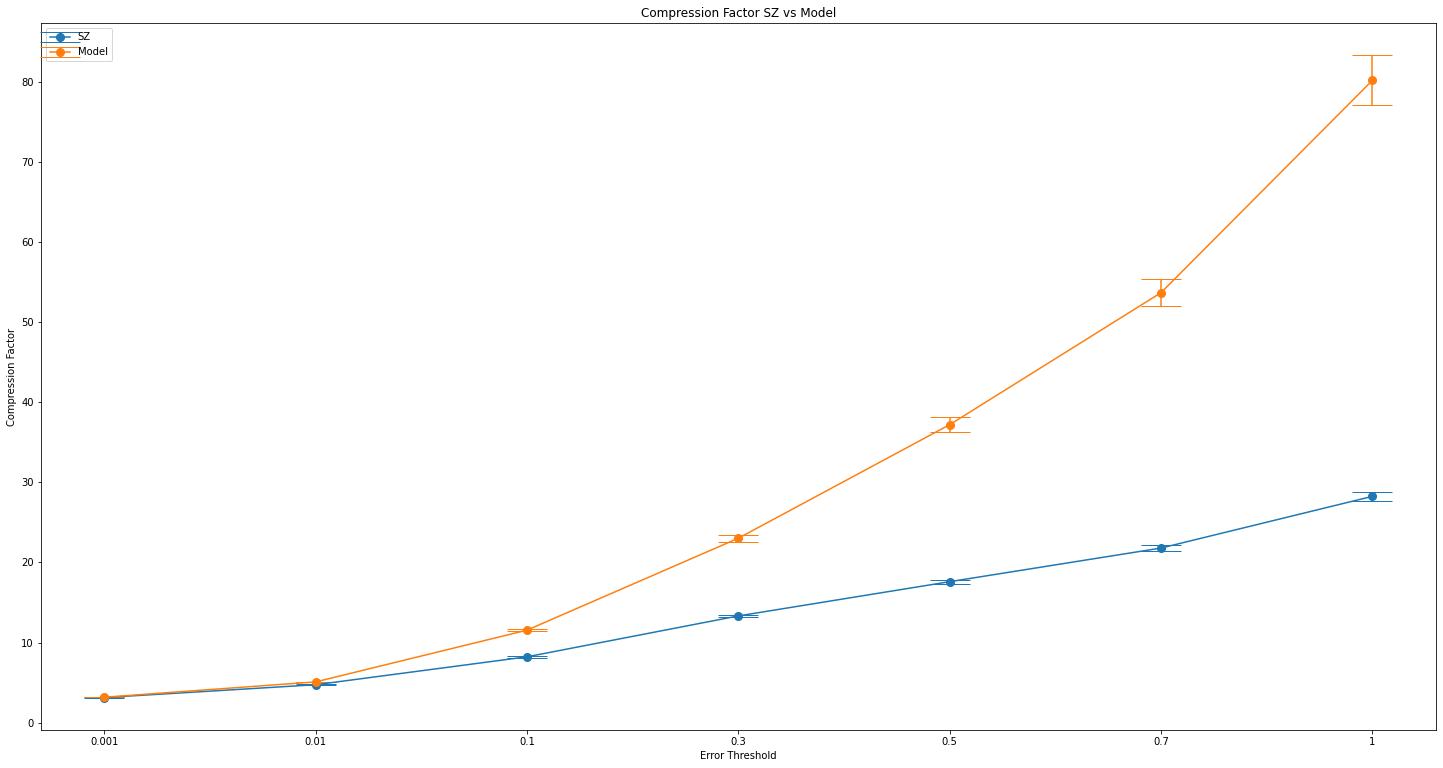

In [9]:
plt.figure(figsize=(25,13))
plt.title("Compression Factor SZ vs Model")
plt.ylabel("Compression Factor")
plt.xlabel("Error Threshold")

#(_, caps, _) = plt.errorbar(
#    data_mod['model'].keys(), means_mod,yerr = [std_mod,std_mod],fmt='-o', markersize=8, capsize=20, label = 'Model 100k Samples with np.diff')

(_, caps, _) = plt.errorbar(
    data_mod['model'].keys(), means_sz, yerr = [std_sz, std_sz],fmt='-o', markersize=8, capsize=20, label = "SZ")

#(_, caps, _) = plt.errorbar(
#    data_mod2['model'].keys(), means_mod2, yerr = [std_mod2, std_mod2],fmt='-o', markersize=8, capsize=20, label = "Model 400k Samples with np.diff")

(_, caps, _) = plt.errorbar(
    data_mod3['model'].keys(), means_mod3, yerr = [std_mod3, std_mod3],fmt='-o', markersize=8, capsize=20, label = "Model")

#(_, caps, _) = plt.errorbar(
#    data_mod3['model'].keys(), means_mod4, yerr = [std_mod4, std_mod4],fmt='-o', markersize=8, capsize=20, label = "Model 400k Samples witH Time - np.diff")

for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.legend()

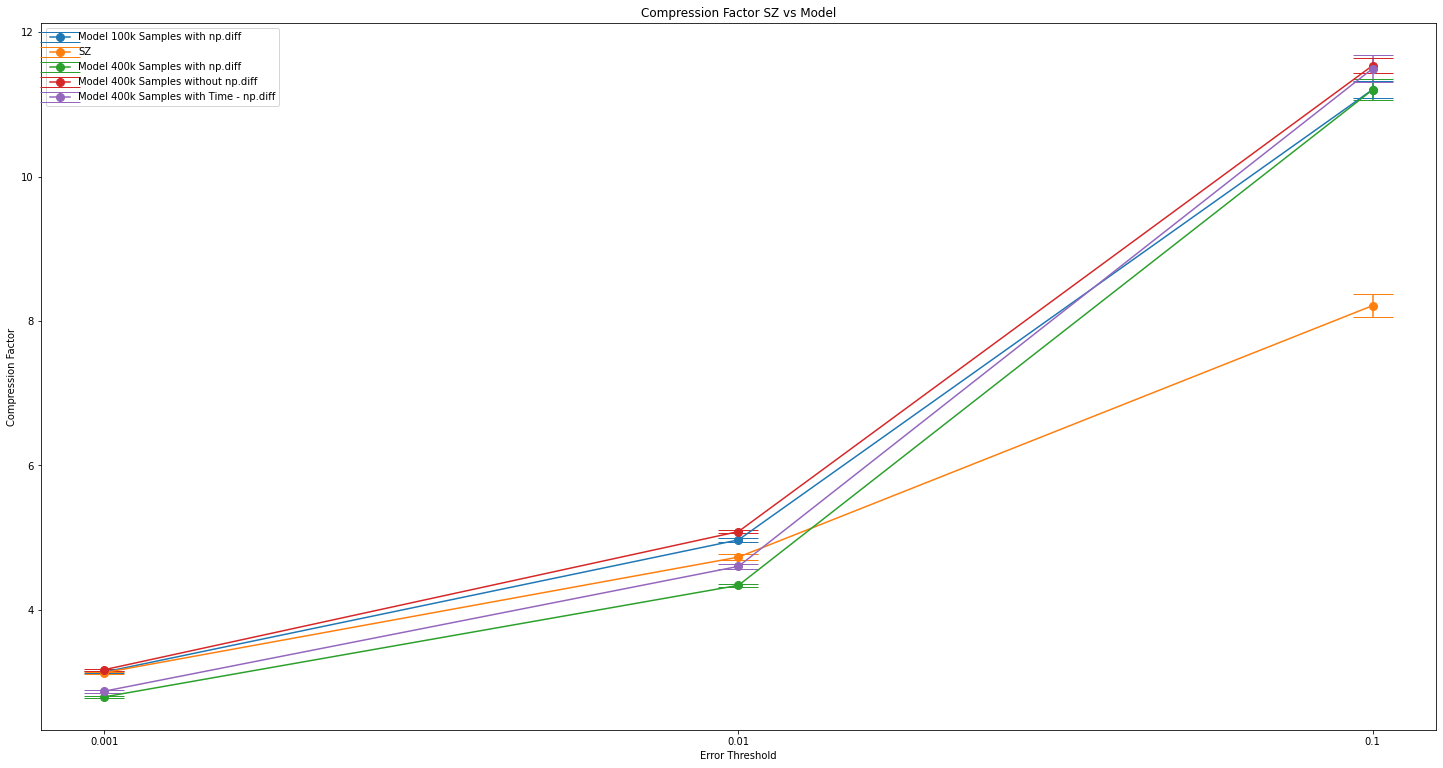

In [10]:
plt.figure(figsize=(25,13))
plt.title("Compression Factor SZ vs Model")
plt.ylabel("Compression Factor")
plt.xlabel("Error Threshold")


x = list(data_mod['model'].keys())[0:3]

(_, caps, _) = plt.errorbar(
    x, means_mod[0:3],yerr = [std_mod[0:3][0:3],std_mod[0:3]],fmt='-o', markersize=8, capsize=20, label = 'Model 100k Samples with np.diff')

(_, caps, _) = plt.errorbar(
    x, means_sz[0:3], yerr = [std_sz[0:3], std_sz[0:3]],fmt='-o', markersize=8, capsize=20, label = "SZ")

(_, caps, _) = plt.errorbar(
    x, means_mod2[0:3], yerr = [std_mod2[0:3], std_mod2[0:3]],fmt='-o', markersize=8, capsize=20, label = "Model 400k Samples with np.diff")

(_, caps, _) = plt.errorbar(
    x, means_mod3[0:3], yerr = [std_mod3[0:3], std_mod3[0:3]],fmt='-o', markersize=8, capsize=20, label = "Model 400k Samples without np.diff")

(_, caps, _) = plt.errorbar(
    x, means_mod4[0:3], yerr = [std_mod4[0:3], std_mod4[0:3]],fmt='-o', markersize=8, capsize=20, label = "Model 400k Samples with Time - np.diff")

for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.legend()

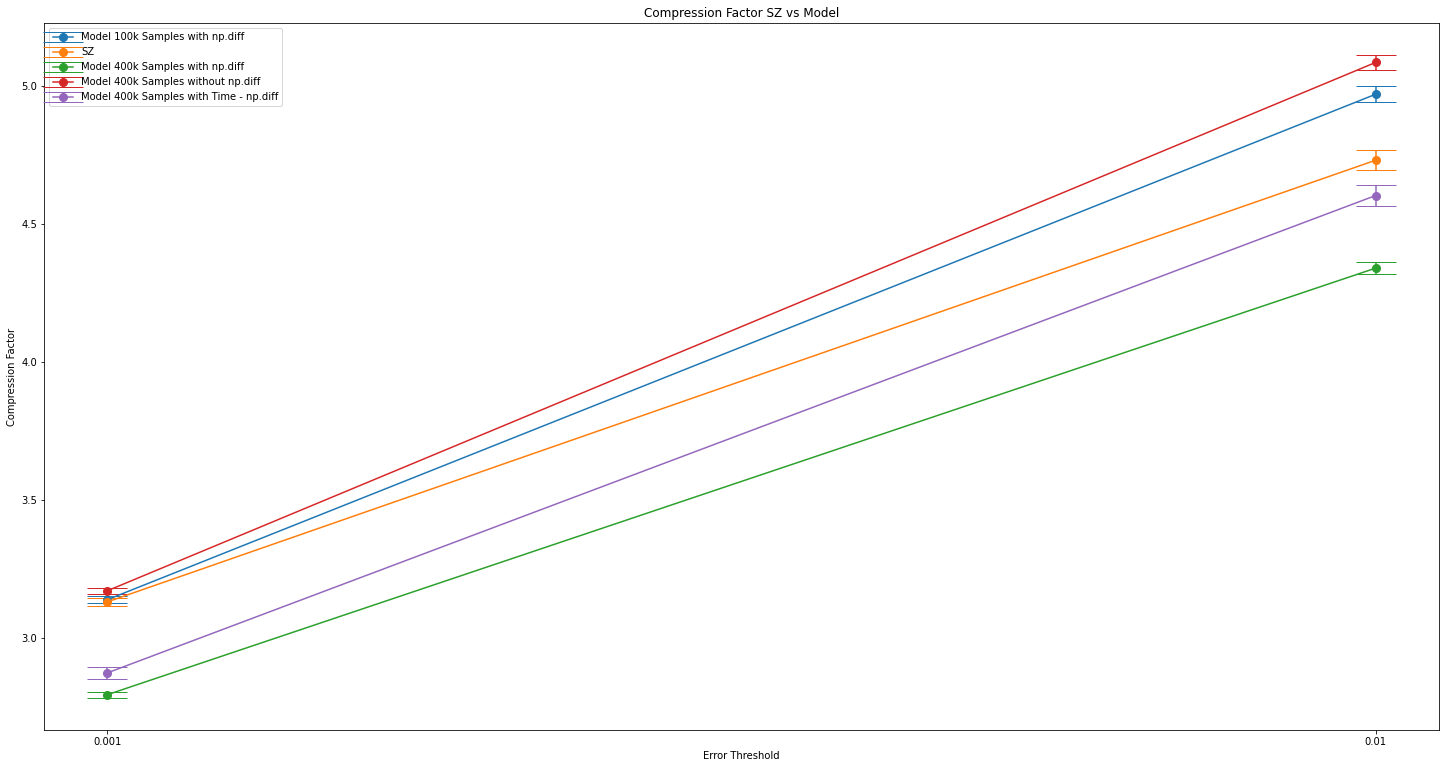

In [11]:
plt.figure(figsize=(25,13))
plt.title("Compression Factor SZ vs Model")
plt.ylabel("Compression Factor")
plt.xlabel("Error Threshold")


x = list(data_mod['model'].keys())[0:2]

(_, caps, _) = plt.errorbar(
    x, means_mod[0:2],yerr = [std_mod[0:2][0:2],std_mod[0:2]],fmt='-o', markersize=8, capsize=20, label = 'Model 100k Samples with np.diff')

(_, caps, _) = plt.errorbar(
    x, means_sz[0:2], yerr = [std_sz[0:2], std_sz[0:2]],fmt='-o', markersize=8, capsize=20, label = "SZ")

(_, caps, _) = plt.errorbar(
    x, means_mod2[0:2], yerr = [std_mod2[0:2], std_mod2[0:2]],fmt='-o', markersize=8, capsize=20, label = "Model 400k Samples with np.diff")

(_, caps, _) = plt.errorbar(
    x, means_mod3[0:2], yerr = [std_mod3[0:2], std_mod3[0:2]],fmt='-o', markersize=8, capsize=20, label = "Model 400k Samples without np.diff")

(_, caps, _) = plt.errorbar(
    x, means_mod4[0:2], yerr = [std_mod4[0:2], std_mod4[0:2]],fmt='-o', markersize=8, capsize=20, label = "Model 400k Samples with Time - np.diff")

for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.legend()

In [186]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import keras.backend as K
import xarray as xr
from lossycomp.models import Autoencoder
from lossycomp.encodings import encode_lat, encode_lon

def mean_squared_error_5(y_true, y_pred):
    """Calculates the MSE if we have more than one channel
    Args:
    =======
        y_true: real value.
        y_pred: predicted value.
    Returns the MSE."""
    gauss_kernel = True
    
    type(y_true)
    
    if gauss_kernel:
        y_shape = y_pred.shape
        ker = gaussian_kernel(b = y_shape[0], d=y_shape[1] , l=y_shape[2], sig =2)
        ker = tf.constant(ker, dtype= np.float32)        
        y_1 = y_pred[:,:,:,:,0] *  ker
        y_2 = y_true[:,:,:,:,0] *  ker
        return K.mean(K.square(y_1 - y_2), axis=-1)
    else:
        return K.mean(K.square(y_pred[:,:,:,:,0] - y_true[:,:,:,:,0]), axis=-1)


def gaussian_kernel(b =1, d=16 , l=48, sig=1.):
    """
    Creates a Gaussian kernel with side length l and a sigma of sig.
    Args:
    ======
        l = length of the kernel (height and width have same length).
        sig = sigma of the kernel.
    Returns a 3D - Gaussian kernel, the first dimension is just the 2D Gk repeated d times.
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    kernel = (kernel / np.sum(kernel)) + 1
    
    kernel[kernel>1] +=1
    
    kernel = np.repeat(kernel[np.newaxis, :, :], d, axis=0)
    
    kernel = np.repeat(kernel[np.newaxis, :, :], b, axis=0)
    
    return kernel

In [70]:
(encoder, decoder, model) = Autoencoder.build(16, 48, 48, 5, filters = (10, 20, 20, 20))
model.load_weights('../results/models_70_epochs_try/weights/weight.hdf5')

In [43]:
data_or = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc', combine='by_coords')
data_or = data_or.sel(time=slice('1980-10-14T16:00:00','1980-10-15T07:00:00'),level = slice(978,1000), longitude=slice(0,11.8), latitude=slice(0,-11.8))
data_or = data_or.transpose('time', 'latitude', 'longitude', 'level')

lat = data_or['t'].coords['latitude'].values
lon = data_or['t'].coords['longitude'].values

lat_st = np.stack([encode_lat(x) for x in lat])
lon_st = np.stack([encode_lon(x) for x in lon])

lat1, lat2 = np.hsplit(lat_st, 2)
lon1, lon2 = np.hsplit(lon_st, 2)

xx, yy = np.meshgrid(lon1, lat1)
xx2, yy2 = np.meshgrid(lon2, lat2)

coords_lat = np.concatenate([[xx]] * len(data_or.time), axis=0)
coords_lon = np.concatenate([[yy]] * len(data_or.time), axis=0)
coords_lat1 = np.concatenate([[xx2]] * len(data_or.time), axis=0)
coords_lon1 = np.concatenate([[yy2]] * len(data_or.time), axis=0)

coords_lat = np.expand_dims(coords_lat, axis=3)
coords_lon = np.expand_dims(coords_lon, axis=3)

coords_lat1 = np.expand_dims(coords_lat1, axis=3)
coords_lon1 = np.expand_dims(coords_lon1, axis=3)

temp = data_or['t'].values
data_or =  np.concatenate((temp, coords_lat, coords_lon, coords_lat1, coords_lon1 ),axis = 3)

data_or = np.expand_dims(data_or, axis=0)
data_or = np.array(data_or, dtype = np.float32)

data_or.shape

(1, 16, 48, 48, 5)

In [125]:
data_or = (data_or- np.mean(data_or))/ (np.std(data_or))

In [126]:
res = model(data_or)

In [187]:
mse = mean_squared_error_5(tf.constant(data_or),res)

In [188]:
mse.numpy()

array([[[8.14018364e-04, 4.14937764e-04, 3.84169281e-04, 4.36489237e-04,
         2.34505438e-04, 1.59094881e-04, 1.81864554e-04, 3.37138626e-04,
         3.33955628e-04, 4.32556175e-04, 7.24282581e-04, 8.50491517e-04,
         9.64330509e-04, 1.28966570e-03, 1.71638245e-03, 1.65696593e-03,
         1.47643930e-03, 1.09490973e-03, 1.10041525e-03, 8.06176744e-04,
         5.00716502e-04, 5.87509538e-04, 8.65498558e-04, 8.85083340e-04,
         9.35190124e-04, 9.94266942e-04, 1.25968875e-03, 1.45371584e-03,
         1.68330164e-03, 2.09135632e-03, 2.31201900e-03, 2.09097168e-03,
         1.76394219e-03, 1.20812643e-03, 1.04043412e-03, 7.38344796e-04,
         4.77337540e-04, 5.39968547e-04, 5.87248767e-04, 4.49883431e-04,
         3.46139685e-04, 3.80310696e-04, 5.44807699e-04, 4.00337856e-04,
         4.84615797e-04, 3.14691075e-04, 2.18536297e-04, 4.07529442e-04],
        [5.97996695e-04, 3.01697321e-04, 3.88395973e-04, 2.97323655e-04,
         2.10856480e-04, 2.57339212e-04, 3.0329215

In [189]:
mse_2 = tf.keras.losses.MSE(tf.constant(data_or[:,:,:,:,0]),res[:,:,:,:,0]).numpy()

In [190]:
np.all(mse==mse_2)

False

In [191]:
c = np.in1d(mse[0,0,:], mse_2[0,0,:])

In [192]:
mse_2.shape

(1, 16, 48)

In [193]:
mse.shape

TensorShape([1, 16, 48])

In [194]:
c

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True])

In [195]:
mse[0,0,:]

<tf.Tensor: shape=(48,), dtype=float32, numpy=
array([0.00081402, 0.00041494, 0.00038417, 0.00043649, 0.00023451,
       0.00015909, 0.00018186, 0.00033714, 0.00033396, 0.00043256,
       0.00072428, 0.00085049, 0.00096433, 0.00128967, 0.00171638,
       0.00165697, 0.00147644, 0.00109491, 0.00110042, 0.00080618,
       0.00050072, 0.00058751, 0.0008655 , 0.00088508, 0.00093519,
       0.00099427, 0.00125969, 0.00145372, 0.0016833 , 0.00209136,
       0.00231202, 0.00209097, 0.00176394, 0.00120813, 0.00104043,
       0.00073834, 0.00047734, 0.00053997, 0.00058725, 0.00044988,
       0.00034614, 0.00038031, 0.00054481, 0.00040034, 0.00048462,
       0.00031469, 0.00021854, 0.00040753], dtype=float32)>

In [196]:
mse_2[0,0,:]

array([0.00081402, 0.00041494, 0.00038417, 0.00043649, 0.00023451,
       0.00015909, 0.00018186, 0.00033714, 0.00022477, 0.00020996,
       0.00029665, 0.00031857, 0.00034495, 0.00044504, 0.00055336,
       0.00054039, 0.00044109, 0.00035051, 0.00033271, 0.0002479 ,
       0.00015667, 0.00019244, 0.00026169, 0.00030681, 0.00028151,
       0.00032713, 0.00039629, 0.00048556, 0.00055357, 0.0007092 ,
       0.00076329, 0.00074046, 0.00059668, 0.00044428, 0.0003668 ,
       0.00028689, 0.00021975, 0.00029486, 0.00031964, 0.00032988,
       0.00034614, 0.00038031, 0.00054481, 0.00040034, 0.00048462,
       0.00031469, 0.00021854, 0.00040753], dtype=float32)

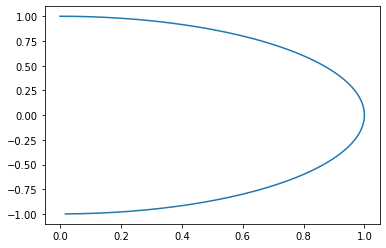

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import math

lat = list(range(180))
lon = list(range(360))

def coord1(lat):
    lat = lat / 180
    return math.sin( math.pi * lat), math.cos(math.pi * lat)

def coord2(lon):
    lon = lon / 360
    return math.sin(2 * math.pi * lon), math.cos(2 * math.pi * lon)

x_lat = []
y_lat = []
for i in lat:
    x_lat.append(coord1(i)[0])
    y_lat.append(coord1(i)[1])
    

x_lon = []
y_lon = []
for i in lon:
    x_lon.append(coord2(i)[0])
    y_lon.append(coord2(i)[1])

plt.plot(x_lat, y_lat)



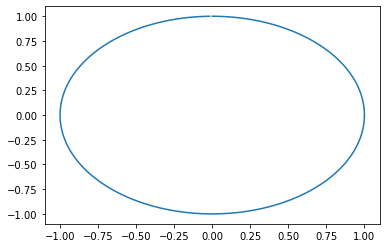

In [17]:
plt.plot(x_lon, y_lon)